In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import os
import numpy as np
from scipy.linalg import sqrtm
from skimage.transform import resize
from keras.datasets import cifar10, mnist
import matplotlib.pyplot as plt


In [2]:
# Laden des vortrainierten Inception-v3-Modells
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [3]:
# Berechnung der FID
def calculate_fid(model, images1, images2):
    # Aktivierungen berechnen
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Berechnug des Mittelwertes und der Kovarianz beider Verteilungen
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Berechnung der summe der quadrierten Differenzen zwischen den Mittelwerten (Skalaprodukt der Differenz)
    sum_diff = np.sum((mu1 - mu2)**2.0)

    # Berechnung der Wurzel des Punktproduktes zwischen beiden Kovarianzmatrizen
    covmean = sqrtm(sigma1.dot(sigma2))

    # Überprüfung sowie korrektur falls imaginäre Zahlen entstanden sind
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Berechne den FID
    fid = sum_diff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [4]:
# Bilder in einem Array auf die richtige Größe bringen
def scale_images(images):
 images_hold = list()
 for image in images:
    # Größe des Bildes ändern
    new_image = resize(image, (299,299,3), 0)
    # die neuen Bilder zwischenspeichern
    images_hold.append(new_image)
 return np.asarray(images_hold)

In [5]:
# CIFAR10 Trainingsbilder & MNIST Testbilder

# Zum testen des FIDs laden wir CIFAR10 Bilder. images1: 50 000 Trainingsbilder, images2 = 10 000 Testbilder 
(r_images1,_), (_,_) = cifar10.load_data()
(_,_), (r_images2,_) = mnist.load_data()


# Die Trainingsbilder durchmischen und 10 000 auswählen.
np.random.shuffle(r_images1)
images1 = r_images1[:10000]

# Integer Werte in Float Werte umwandeln.
images1 = images1.astype('float32')
images2 = r_images2.astype('float32')

# Bildgrößen anpassen
images1 = scale_images(images1)
images2 = scale_images(images2)

# Bilder normalisieren
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

#FID berechnen
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

313/313 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step
FID: 268.201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


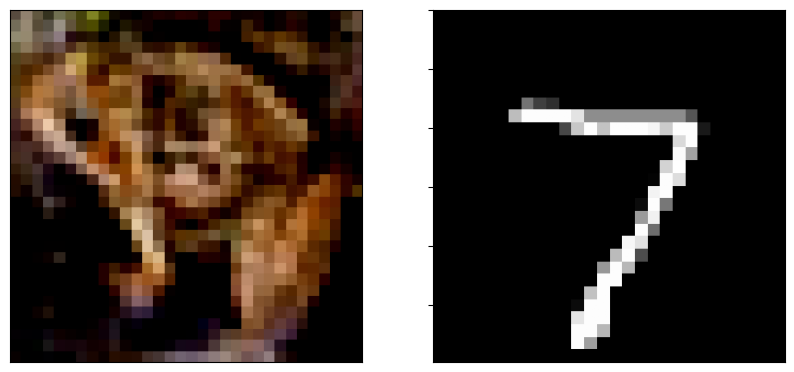

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharey=True, sharex=True)

img1 = images1[0] 
img2 = images2[0] 

ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax1.imshow(img1)
ax2.imshow(img2)
